## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerImageProcessor

root_dir = './ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/Users/odai/cs5567-final-project/.venv/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

In [14]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [15]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [16]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]])

In [17]:
batch["labels"][mask]

tensor([ 0,  0,  0,  ..., 13, 13, 13])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/Users/odai/cs5567-final-project/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [20]:
image_processor.do_reduce_labels

True

In [21]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/odai/cs5567-final-project/.venv/lib/python3.11/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/Users/odai/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/odai/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.157630443572998
Mean_iou: 5.773313284743305e-06
Mean accuracy: 8.741902237926973e-05
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 5.01762056350708
Mean_iou: 0.00025463780451448503
Mean accuracy: 0.003556599803508071
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.866004943847656
Mean_iou: 0.002795297312968546
Mean accuracy: 0.020066457936154622
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.724591255187988
Mean_iou: 0.014171833539631007
Mean accuracy: 0.10635422266384183
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.6059770584106445
Mean_iou: 0.017558094041534654
Mean accuracy: 0.1830636209856178
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.605180740356445
Mean_iou: 0.009790055728000143
Mean accuracy: 0.06462014573275257
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.26498556137085
Mean_iou: 0.04309937533051759
Mean accuracy: 0.3711286272848657
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.190200328826904
Mean_iou: 0.044588976606243454
Mean accuracy: 0.39980461149149865
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.184525489807129
Mean_iou: 0.07426146182925208
Mean accuracy: 0.46839374870721223
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.020797252655029
Mean_iou: 0.07372488417739229
Mean accuracy: 0.26460534068095726
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.551791191101074
Mean_iou: 0.1613093072071879
Mean accuracy: 0.66765008771857
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8761675357818604
Mean_iou: 0.09636500238707225
Mean accuracy: 0.47791367850642763
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8166239261627197
Mean_iou: 0.08770607929040722
Mean accuracy: 0.2833580025537059
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3166658878326416
Mean_iou: 0.17574878075156114
Mean accuracy: 0.5041489242270211
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2957582473754883
Mean_iou: 0.28637506893932824
Mean accuracy: 0.5204167499239527
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3456497192382812
Mean_iou: 0.16679172015123225
Mean accuracy: 0.369550053269898
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2728285789489746
Mean_iou: 0.26871299571488627
Mean accuracy: 0.4402393545068521
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.018946409225464
Mean_iou: 0.18224942153143456
Mean accuracy: 0.31349757572109704
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.050112009048462
Mean_iou: 0.20430177465234267
Mean accuracy: 0.40335310619913395
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.03761625289917
Mean_iou: 0.17903584075612258
Mean accuracy: 0.3589374485357823
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.969022750854492
Mean_iou: 0.3246306190115673
Mean accuracy: 0.7483242679085379
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.824208974838257
Mean_iou: 0.153462203607042
Mean accuracy: 0.2264465398988095
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8293962478637695
Mean_iou: 0.24968231808911612
Mean accuracy: 0.5408405883747968
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.207899570465088
Mean_iou: 0.2610008426220291
Mean accuracy: 0.4935692253077723
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8297312259674072
Mean_iou: 0.3220158497955506
Mean accuracy: 0.6623344378353961
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7175803184509277
Mean_iou: 0.33273790694656546
Mean accuracy: 0.5039038512444476
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0865895748138428
Mean_iou: 0.21303858877386198
Mean accuracy: 0.3744840816778067
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5476081371307373
Mean_iou: 0.474763778252103
Mean accuracy: 0.7289531622649416
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.576509952545166
Mean_iou: 0.3137431293001531
Mean accuracy: 0.540615790171335
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4354727268218994
Mean_iou: 0.15523190273422566
Mean accuracy: 0.21723071532308025
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.410309314727783
Mean_iou: 0.40103598428252224
Mean accuracy: 0.5378221117093213
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4341719150543213
Mean_iou: 0.18439725069423324
Mean accuracy: 0.27284247384963195
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9274232387542725
Mean_iou: 0.2668354269157736
Mean accuracy: 0.372399273063384
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.619093656539917
Mean_iou: 0.28648141086345746
Mean accuracy: 0.5033720154558252
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.299234390258789
Mean_iou: 0.19386324101471944
Mean accuracy: 0.2693899336011953
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6441919803619385
Mean_iou: 0.41651015149720305
Mean accuracy: 0.7059401232253197
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4101072549819946
Mean_iou: 0.37250775843820283
Mean accuracy: 0.5112684019051477
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.030081033706665
Mean_iou: 0.6506104604297941
Mean accuracy: 0.7628463967794882
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2801536321640015
Mean_iou: 0.3442601171364335
Mean accuracy: 0.5176473696573164
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1467208862304688
Mean_iou: 0.23975825330538592
Mean accuracy: 0.32105312271555564
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5520092248916626
Mean_iou: 0.287568437171563
Mean accuracy: 0.5837806278313329
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1594343185424805
Mean_iou: 0.16382326225895377
Mean accuracy: 0.2905342180968587
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.036332130432129
Mean_iou: 0.32800927257830925
Mean accuracy: 0.5397571878132229
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.785818099975586
Mean_iou: 0.22176073824408582
Mean accuracy: 0.34717256727795404
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.041365146636963
Mean_iou: 0.46774229628533004
Mean accuracy: 0.7178107479546806
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.212878704071045
Mean_iou: 0.08728778863148515
Mean accuracy: 0.16076175539906368
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6549627780914307
Mean_iou: 0.3232154364550345
Mean accuracy: 0.4285618107355566
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.600999116897583
Mean_iou: 0.31204044673286907
Mean accuracy: 0.42431076286654984
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8481945395469666
Mean_iou: 0.6420706276744316
Mean accuracy: 0.8271557619930632
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.788238286972046
Mean_iou: 0.19950467748533054
Mean accuracy: 0.28038591028334625
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.577612042427063
Mean_iou: 0.27769005101039773
Mean accuracy: 0.4125635074191919
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2917927503585815
Mean_iou: 0.2783425518633327
Mean accuracy: 0.3906332712345075
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4086501598358154
Mean_iou: 0.19392806083657554
Mean accuracy: 0.25489071156520665
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2385085821151733
Mean_iou: 0.3021417805350176
Mean accuracy: 0.3910857814869554
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0940217971801758
Mean_iou: 0.4010579834896752
Mean accuracy: 0.6343483492453249
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.377166748046875
Mean_iou: 0.3575347274801482
Mean accuracy: 0.4953220999385351
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9749464988708496
Mean_iou: 0.4380703230590907
Mean accuracy: 0.5309135203200903
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0978667736053467
Mean_iou: 0.38245994614670104
Mean accuracy: 0.6485168746919505
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4570860862731934
Mean_iou: 0.15678256347759192
Mean accuracy: 0.22583598568528485
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1909245252609253
Mean_iou: 0.2646149474068186
Mean accuracy: 0.38827501319117047
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5521670579910278
Mean_iou: 0.2638917875299907
Mean accuracy: 0.3345275846472553
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3772684335708618
Mean_iou: 0.36888365371096066
Mean accuracy: 0.4942083331271814
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2944648265838623
Mean_iou: 0.3850793991918933
Mean accuracy: 0.46780332018879645
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.292723536491394
Mean_iou: 0.46143761013941503
Mean accuracy: 0.5824222138650728
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4495842456817627
Mean_iou: 0.4352197013644813
Mean accuracy: 0.562138886865125
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3148138523101807
Mean_iou: 0.25784970838891114
Mean accuracy: 0.41074514441710624
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.244401454925537
Mean_iou: 0.49103658745205697
Mean accuracy: 0.6366290769101994
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1949224472045898
Mean_iou: 0.35286694572726135
Mean accuracy: 0.4437364343069375
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2811094522476196
Mean_iou: 0.4197988861750058
Mean accuracy: 0.5467977283745291
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9986174702644348
Mean_iou: 0.4974723448781815
Mean accuracy: 0.7135865205637936
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.232262372970581
Mean_iou: 0.16150311556281466
Mean accuracy: 0.2550776644042317
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48236802220344543
Mean_iou: 0.8107284965931048
Mean accuracy: 0.8477358239086741
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3635705709457397
Mean_iou: 0.37894701075665926
Mean accuracy: 0.46409660328983326
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1168687343597412
Mean_iou: 0.4804843338817636
Mean accuracy: 0.6289697155238027
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2779515981674194
Mean_iou: 0.40333809790620107
Mean accuracy: 0.48328789302996256
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4495725631713867
Mean_iou: 0.8119309018402942
Mean accuracy: 0.8567134718771947
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0062605142593384
Mean_iou: 0.48808738172674154
Mean accuracy: 0.5727819163245792
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.618861198425293
Mean_iou: 0.6096621481980559
Mean accuracy: 0.7777516103130178
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0805820226669312
Mean_iou: 0.3366534651419773
Mean accuracy: 0.44324378495412226
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2217425107955933
Mean_iou: 0.4084115279986413
Mean accuracy: 0.4765201988707516
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3733719289302826
Mean_iou: 0.6546494044734277
Mean accuracy: 0.8446745329780001
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9749413728713989
Mean_iou: 0.5482644048003803
Mean accuracy: 0.6623160242712824
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0896484851837158
Mean_iou: 0.315976873885349
Mean accuracy: 0.4338836800251404
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0294097661972046
Mean_iou: 0.3053011474630423
Mean accuracy: 0.4397099877504271
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6601794362068176
Mean_iou: 0.4234673890113137
Mean accuracy: 0.6719196548685904
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.206836462020874
Mean_iou: 0.3999641863586126
Mean accuracy: 0.6170005094034188
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8307139277458191
Mean_iou: 0.4849396615794947
Mean accuracy: 0.5646585108120347
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8875569701194763
Mean_iou: 0.1350739829018325
Mean accuracy: 0.2187770128312886
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28505560755729675
Mean_iou: 0.3714303943726979
Mean accuracy: 0.6172695333578069
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.875614583492279
Mean_iou: 0.4193036279955349
Mean accuracy: 0.49186670069691224
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.10074782371521
Mean_iou: 0.46920544559965227
Mean accuracy: 0.5811933427623256
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44805198907852173
Mean_iou: 0.7943693204616045
Mean accuracy: 0.8418181725411208
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9733134508132935
Mean_iou: 0.17865290027079653
Mean accuracy: 0.27972807107180014
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.693233847618103
Mean_iou: 0.31503655718389983
Mean accuracy: 0.4624316738135623
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6960419416427612
Mean_iou: 0.29228074454238495
Mean accuracy: 0.3344657340894273
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3927336037158966
Mean_iou: 0.3925383892390151
Mean accuracy: 0.6060454975860278
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0474233627319336
Mean_iou: 0.3652511257445958
Mean accuracy: 0.43324685076253044
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9463714957237244
Mean_iou: 0.34367851343320854
Mean accuracy: 0.4569367595430756
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8015128970146179
Mean_iou: 0.6487860809400379
Mean accuracy: 0.6809811689981612
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7253444194793701
Mean_iou: 0.6736154349810795
Mean accuracy: 0.7217405318884488
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.006135106086731
Mean_iou: 0.629387462086861
Mean accuracy: 0.6591591317303376
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7527155876159668
Mean_iou: 0.48006919792178077
Mean accuracy: 0.5290215626368249
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1089781522750854
Mean_iou: 0.20884374400112776
Mean accuracy: 0.2772236395016775
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5852439999580383
Mean_iou: 0.8390173392434377
Mean accuracy: 0.871976520605306
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5860825777053833
Mean_iou: 0.7611817031200198
Mean accuracy: 0.8154277339309107
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20005251467227936
Mean_iou: 0.3824264771603522
Mean accuracy: 0.6795340710035791
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9498773217201233
Mean_iou: 0.4160008823979332
Mean accuracy: 0.46564235783030344
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4500183165073395
Mean_iou: 0.4169960631590939
Mean accuracy: 0.6450212955342409
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7150894403457642
Mean_iou: 0.27604182944112293
Mean accuracy: 0.4229314447479994
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5444684624671936
Mean_iou: 0.7940085930657689
Mean accuracy: 0.8372277439356028
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8811429738998413
Mean_iou: 0.33390459150160645
Mean accuracy: 0.3763864389600637
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7160012125968933
Mean_iou: 0.40586055614545724
Mean accuracy: 0.4687615214296301
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47517409920692444
Mean_iou: 0.5721928052738641
Mean accuracy: 0.6458437799220076
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5492013692855835
Mean_iou: 0.7417137145849683
Mean accuracy: 0.8020074723036668
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6185363531112671
Mean_iou: 0.5263929676222049
Mean accuracy: 0.5950829563109657
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6558547019958496
Mean_iou: 0.7064037393429967
Mean accuracy: 0.7527570426721705
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7756465673446655
Mean_iou: 0.3093687740742872
Mean accuracy: 0.3657248292959561
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5724385976791382
Mean_iou: 0.371710024337917
Mean accuracy: 0.46474215420166426
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7698224186897278
Mean_iou: 0.32127518958679835
Mean accuracy: 0.36581025446810167
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8300050497055054
Mean_iou: 0.44964478988987366
Mean accuracy: 0.5020261789830965
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24320575594902039
Mean_iou: 0.8479805870099648
Mean accuracy: 0.8750176274013882
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5182985067367554
Mean_iou: 0.4615911374329774
Mean accuracy: 0.5605768380776452
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5085915327072144
Mean_iou: 0.39665227574007683
Mean accuracy: 0.6359824545958743
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5948081612586975
Mean_iou: 0.4705429906118331
Mean accuracy: 0.5366238219076651
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6471891403198242
Mean_iou: 0.5944630926451608
Mean accuracy: 0.6729376476953904
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5195187926292419
Mean_iou: 0.4360795349479681
Mean accuracy: 0.4825661355246272
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5403316020965576
Mean_iou: 0.38409131719378753
Mean accuracy: 0.531572224014513
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7004069089889526
Mean_iou: 0.5539514387029139
Mean accuracy: 0.6507399699870808
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5171500444412231
Mean_iou: 0.605453057782736
Mean accuracy: 0.6919970471158841
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48085370659828186
Mean_iou: 0.3579125942115661
Mean accuracy: 0.5077040786806315
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5547998547554016
Mean_iou: 0.674121591306799
Mean accuracy: 0.7178948917221736
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3502289056777954
Mean_iou: 0.5991342689962854
Mean accuracy: 0.7440010289939211
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32914409041404724
Mean_iou: 0.5551248216942172
Mean accuracy: 0.6134851954751539
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4524907171726227
Mean_iou: 0.8240273618397232
Mean accuracy: 0.8741776616626741
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7156578302383423
Mean_iou: 0.31984874840403504
Mean accuracy: 0.36572139703217443
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7350754141807556
Mean_iou: 0.18666017246078973
Mean accuracy: 0.27704684095298854
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5319981575012207
Mean_iou: 0.17738579717255323
Mean accuracy: 0.29931605112006077
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.286212295293808
Mean_iou: 0.5329449310562341
Mean accuracy: 0.7080759773158369
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48949992656707764
Mean_iou: 0.6092713865544589
Mean accuracy: 0.6828411687436369
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3300372362136841
Mean_iou: 0.4762576957945138
Mean accuracy: 0.7448938153778766
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5248031616210938
Mean_iou: 0.46544585349579914
Mean accuracy: 0.5287833733826116
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45831117033958435
Mean_iou: 0.7205525035752934
Mean accuracy: 0.7751631141718285
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.650521993637085
Mean_iou: 0.4633351085945172
Mean accuracy: 0.5064424852257757
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44960108399391174
Mean_iou: 0.5687874717035529
Mean accuracy: 0.6400945983971476
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6382072567939758
Mean_iou: 0.47723159430570106
Mean accuracy: 0.5214153458657572
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37388676404953003
Mean_iou: 0.3565883611844376
Mean accuracy: 0.5582840710790676
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.475009948015213
Mean_iou: 0.5491583254138882
Mean accuracy: 0.5974376142991531
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4521801173686981
Mean_iou: 0.5592790253072246
Mean accuracy: 0.6074079139796295
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5533934831619263
Mean_iou: 0.4975692014664764
Mean accuracy: 0.5376687518832516
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4648468792438507
Mean_iou: 0.3621049002387634
Mean accuracy: 0.5455780578908749
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4908021092414856
Mean_iou: 0.35262299502668204
Mean accuracy: 0.42285458848784757
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5447484254837036
Mean_iou: 0.5192689428429004
Mean accuracy: 0.5756301710590086
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23607857525348663
Mean_iou: 0.4728003141095121
Mean accuracy: 0.7490922661911983
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5011637806892395
Mean_iou: 0.2980713359559687
Mean accuracy: 0.37765148570774915
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6682488322257996
Mean_iou: 0.43644491905843047
Mean accuracy: 0.48122048229981274
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43329131603240967
Mean_iou: 0.38121976260062995
Mean accuracy: 0.5154107824544539
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3706229627132416
Mean_iou: 0.8256593714511631
Mean accuracy: 0.8802185698215201
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44487836956977844
Mean_iou: 0.3211163792229013
Mean accuracy: 0.40793871082969657
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46647199988365173
Mean_iou: 0.5207269787531904
Mean accuracy: 0.557380799404143
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49017584323883057
Mean_iou: 0.1902043929926052
Mean accuracy: 0.27981000718598076
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28105100989341736
Mean_iou: 0.8467891796997439
Mean accuracy: 0.8801000740311423
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6848833560943604
Mean_iou: 0.31501744171199014
Mean accuracy: 0.3754969616192896
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41094765067100525
Mean_iou: 0.6924873635946402
Mean accuracy: 0.7195953836799239
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42030784487724304
Mean_iou: 0.7227279664424745
Mean accuracy: 0.771898597221377
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4240480661392212
Mean_iou: 0.29674236927186237
Mean accuracy: 0.40175609262436557
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4121828079223633
Mean_iou: 0.5735337500718912
Mean accuracy: 0.6236841736865123
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43426308035850525
Mean_iou: 0.29526332358609053
Mean accuracy: 0.3857870286554962
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3881455659866333
Mean_iou: 0.7314272288436866
Mean accuracy: 0.7715843340090247
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1344214677810669
Mean_iou: 0.7402091714145547
Mean accuracy: 0.8479336089434969
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2902989387512207
Mean_iou: 0.9173696567858782
Mean accuracy: 0.9518441457363694
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35051238536834717
Mean_iou: 0.7406568067530586
Mean accuracy: 0.7783487123504128
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.331935316324234
Mean_iou: 0.909356630446327
Mean accuracy: 0.9305682295531237
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5429002642631531
Mean_iou: 0.266975786327278
Mean accuracy: 0.36102048977029416
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6043695211410522
Mean_iou: 0.3010983422834814
Mean accuracy: 0.3673867417270049
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2997114062309265
Mean_iou: 0.4830669941117902
Mean accuracy: 0.5995808577452391
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4126846194267273
Mean_iou: 0.32742783882056714
Mean accuracy: 0.40740671094548975
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4019854664802551
Mean_iou: 0.19088527920981208
Mean accuracy: 0.3118921170843534
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11244355142116547
Mean_iou: 0.9575972813731551
Mean accuracy: 0.9700305636887412
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41673770546913147
Mean_iou: 0.5586865724321285
Mean accuracy: 0.6157821356525927
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4301101565361023
Mean_iou: 0.4826952992167654
Mean accuracy: 0.5791170802070961
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5234103798866272
Mean_iou: 0.47177129222901687
Mean accuracy: 0.5689569315682347
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.340790718793869
Mean_iou: 0.7385101290792387
Mean accuracy: 0.759507488536388
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4054540693759918
Mean_iou: 0.47465514371618345
Mean accuracy: 0.5532236784569787
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46518176794052124
Mean_iou: 0.3538308475771774
Mean accuracy: 0.42528846873976667
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11139009147882462
Mean_iou: 0.8434354310588184
Mean accuracy: 0.8564432707107029
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40812379121780396
Mean_iou: 0.3913451698139229
Mean accuracy: 0.44421972491008993
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3220921456813812
Mean_iou: 0.610830372653105
Mean accuracy: 0.6624282493763921
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5179323554039001
Mean_iou: 0.37531553318089556
Mean accuracy: 0.45175312170450416
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34440532326698303
Mean_iou: 0.6751016903870958
Mean accuracy: 0.7027240362144107
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3343251645565033
Mean_iou: 0.5888742081480652
Mean accuracy: 0.6397878693694184
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4481208622455597
Mean_iou: 0.34228943827807734
Mean accuracy: 0.42670456481671765
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3330289125442505
Mean_iou: 0.7349441935927754
Mean accuracy: 0.7758952316617034
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5557149648666382
Mean_iou: 0.3617344316797382
Mean accuracy: 0.41857416954193133
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26731500029563904
Mean_iou: 0.7553681120007514
Mean accuracy: 0.8786219436668278
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3584330081939697
Mean_iou: 0.6398622628497174
Mean accuracy: 0.7135433397899383
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16697649657726288
Mean_iou: 0.541620298847283
Mean accuracy: 0.7810346345837123
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36852145195007324
Mean_iou: 0.40902388614654955
Mean accuracy: 0.44064682052433446
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28569817543029785
Mean_iou: 0.4844216766335482
Mean accuracy: 0.6215795169391596
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36850500106811523
Mean_iou: 0.5747862918932181
Mean accuracy: 0.6238797025703227
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31458166241645813
Mean_iou: 0.6201519473248224
Mean accuracy: 0.6674308802777913


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

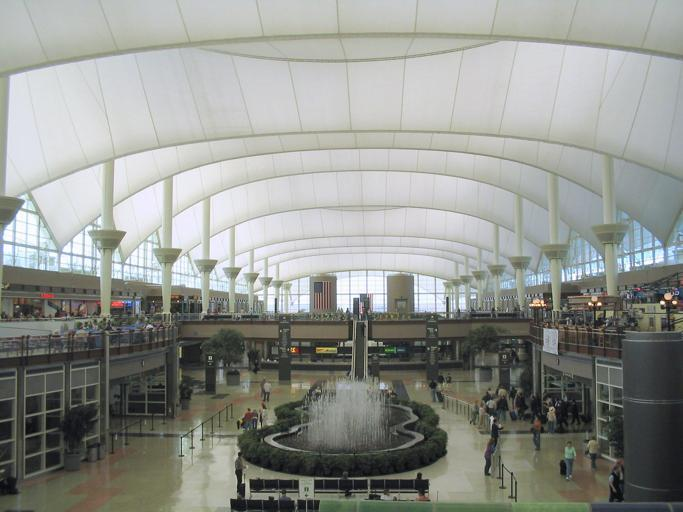

In [22]:
image = Image.open('./ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [23]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [24]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [25]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [26]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [27]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 [0 0 0 ... 5 5 5]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


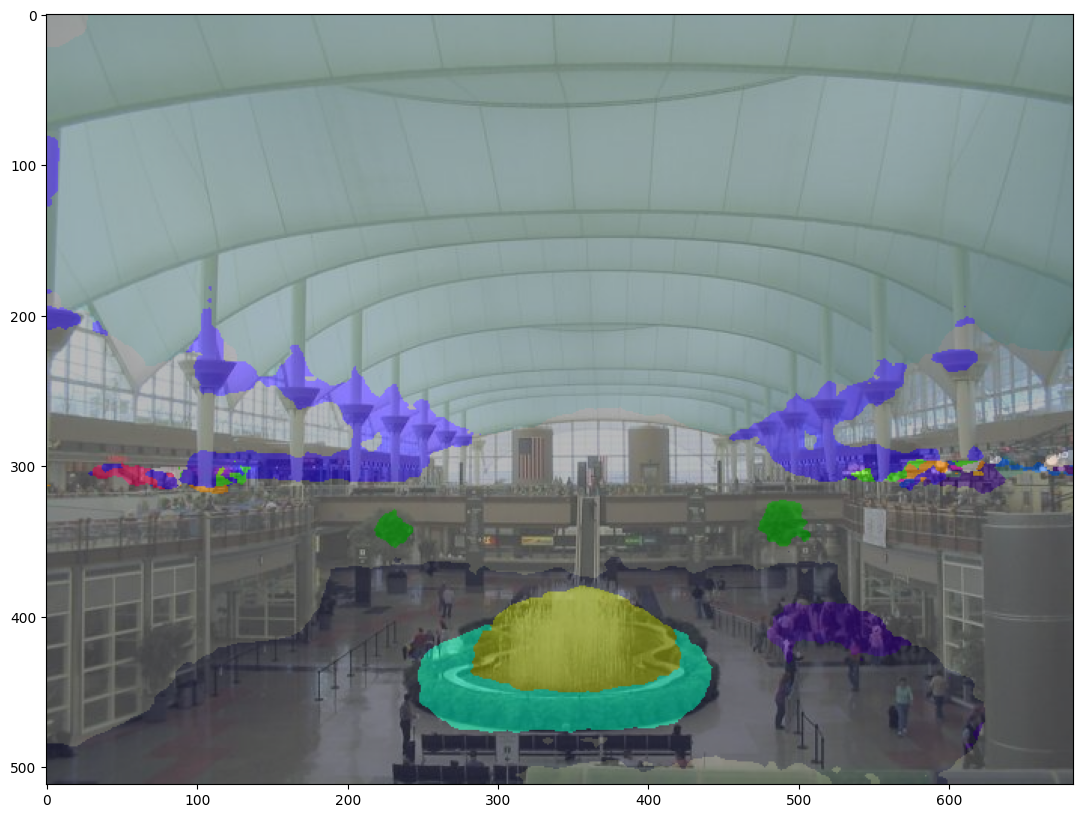

In [28]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

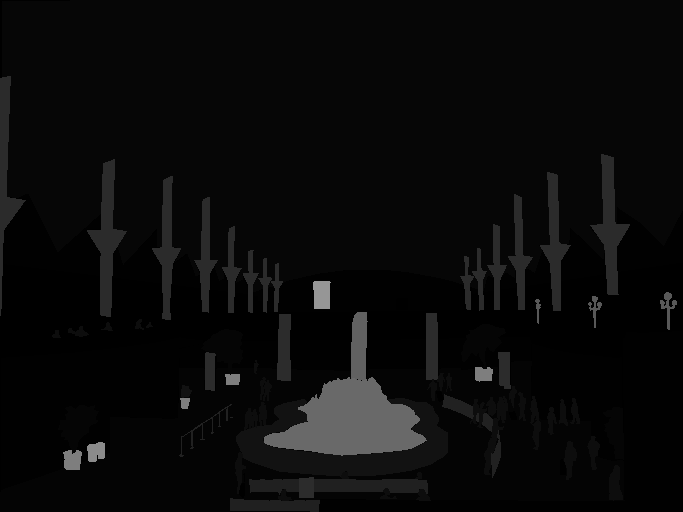

In [29]:
map = Image.open('./ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png')
map

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


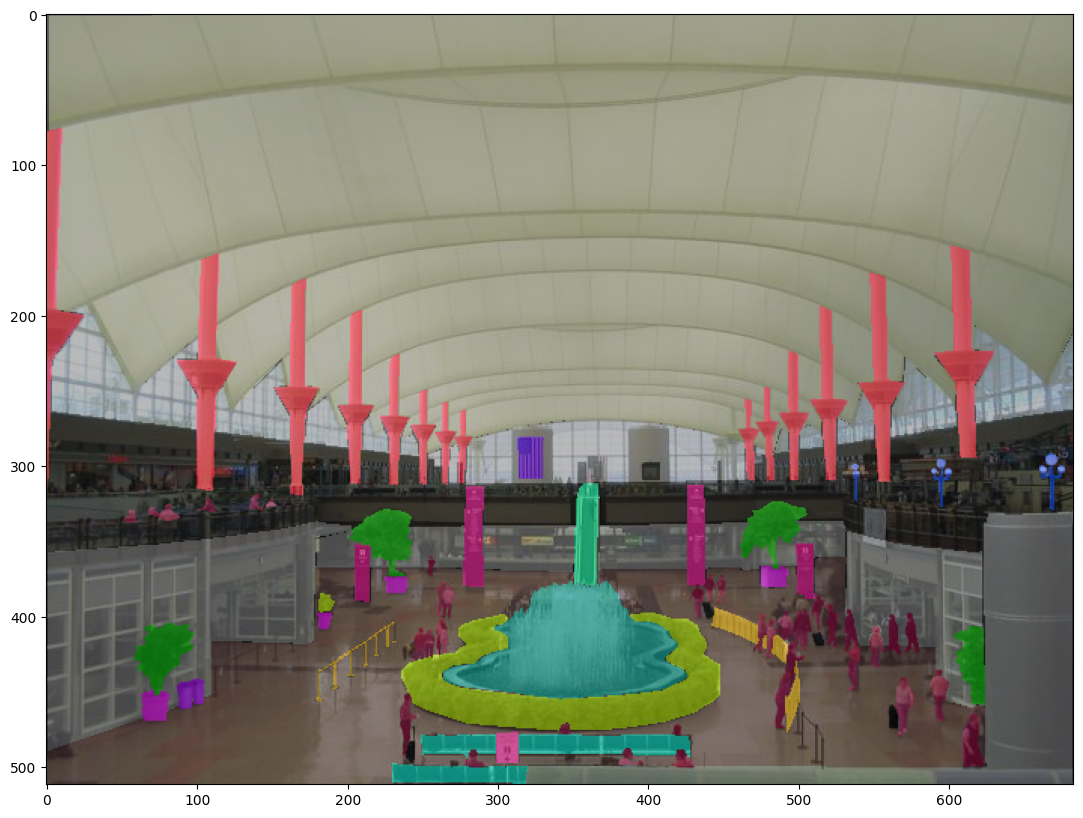

In [30]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [31]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

/Users/odai/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/odai/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [32]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [33]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.20760135120740475
mean_accuracy 0.33514670775737704
overall_accuracy 0.8769019472260197
---------------------
per-category metrics:


,IoU,accuracy
wall,0.755848,0.934963
building,NaN,NaN
sky,NaN,NaN
floor,0.719151,0.940225
tree,0.239033,0.246720
...,...,...
shower,NaN,NaN
radiator,NaN,NaN
glass,NaN,NaN
clock,NaN,NaN


In [34]:
metric_table

{'wall': [0.7558481653978599, 0.9349631974931862],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.7191508513989948, 0.940224586868043],
 'tree': [0.23903290129611166, 0.2467198353485979],
 'ceiling': [0.9423990811979585, 0.9664561411942864],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.0, nan],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.175736568457539, 0.2243362831858407],
 'earth': [0.0, nan],
 'door': [0.0, nan],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.6125014826236508, 0.7590768778480083],
 'curtain': [nan, nan],
 'chair': [nan, nan],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [0.0, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [0.0, 0.0],
 'fence': [0.0, 0.0],
 'desk': [nan, nan],
 'rock': [nan, nan],
 'wardrobe': [nan, nan],
 'lamp': [nan, 

## Spot checking other images

In [35]:
val_imgs = [
    './ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg',
    './ADE20k_toy_dataset/images/training/ADE_train_00000005.jpg',
    './ADE20k_toy_dataset/images/training/ADE_train_00000007.jpg',
]

In [36]:
for k,v in enumerate(val_imgs):
    image = Image.open(v)
    
    # prepare the image for the model
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
    
    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        
    # logits are of shape (batch_size, num_labels, height/4, width/4)
    logits = outputs.logits.cpu()
    
    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

    # create coloured map
    color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[map == label, :] = color
    # Convert to BGR
    color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()
    
    # # metric expects a list of numpy arrays for both predictions and references
    # metrics = metric._compute(
    #                 predictions=[predicted_segmentation_map],
    #                 references=[map],
    #                 num_labels=len(id2label),
    #                 ignore_index=255,
    #                 reduce_labels=False, # we've already reduced the labels ourselves
    #             )
    
    # # print overall metrics
    # for key in list(metrics.keys())[:3]:
    #     print(key, metrics[key])

ValueError: operands could not be broadcast together with shapes (512,711,3) (512,683,3) 